# 🤗 Model Case Study

### Imports and Installs

In [1]:
!pip install transformers
!pip install datasets


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from transformers import pipeline, AutoProcessor, AutoTokenizer, AutoImageProcessor, AutoModelForCausalLM, BlipForConditionalGeneration, Blip2ForConditionalGeneration, VisionEncoderDecoderModel
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image

### Define Models

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [123]:
def generate_captions(model_name, image_path):
    captioner = pipeline(model=model_name)
    return captioner(image_path)[0]["generated_text"]    

### ViP-GPT2

In [5]:
vip_gpt2_pipeline = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
def generate_caption_gpt2(image_path):
    caption = vip_gpt2_pipeline(image_path)[0]["generated_text"]
    return caption

In [11]:
generate_caption_gpt2("../data/flickr8k/Images/667626_18933d713e.jpg")

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a woman in a bikini on a beach '

## BLIP

In [4]:
blip_pipeline = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

In [14]:
blip_pipeline("../data/flickr8k/Images/667626_18933d713e.jpg")[0]["generated_text"]

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a woman in a bikini on a surfboard'

## Git Base

In [126]:
def git_pipeline(image_path):
    processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
    model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

    # url = "../data/flickr8k/Images/667626_18933d713e.jpg"
    image = Image.open(image_path)

    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_caption

## BLIP-2

In [97]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def blip_2_generate_caption(image_path):
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16
    )
    model.to(device)
    image = Image.open(image_path)

    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

    generated_ids = model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
    return generated_text

In [20]:
pipeline2 = pipeline("image-to-text", model="Salesforce/blip2-opt-2.7b")
pipeline2("../data/flickr8k/Images/667626_18933d713e.jpg")[0]["generated_text"]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

: 

: 

## GIT

In [30]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"


def git_pipe(image_path):
    processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
    model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco") 
    
    image = Image.open(f"../data/flickr8k/images/{image_path}")
    # image = image_path
    
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return generated_caption
    # print(generated_caption)

In [9]:
git_pipe("667626_18933d713e.jpg")

a young girl laying on a surfboard in the water.


## Testing Efficacy

In [10]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import random 

In [11]:
with open('/Users/kevinkang/Desktop/brown_cs/cs1430-cv/final/1430CV-image-captioning/data/flickr8k/captions.txt', 'r') as f:
    content = f.read().splitlines()[1:]

image_names = []
for i in range(0,len(content),5):
    image_names.append(content[i].split(',')[0])

In [12]:
#dictionary of index to image name
index_to_image_name = {}
for i, image_name in enumerate(image_names):
    index_to_image_name[i] = image_name

#dictionary of image name to index
image_name_to_index = {}
for i, image_name in enumerate(image_names):
    image_name_to_index[image_name] = i

#dictionary of index to caption
index_to_caption = {}
for i in range(0,len(content),5):
    index_to_caption[int(i/5)] = content[i].split(',')[1]


In [13]:
def get_BLEU_score(model_pipeline, split=None):
    """
    Helper function to calculate the BLEU score of the model on a random subset of the test set.

    :param num_images: the number of images to randomly select from the test set
    :return: the BLEU score
    """

    # train test split
    if split is None:
        split = int(len(image_names)*0.1)

    #shuffle but dont change the original list
    copy_image_names = image_names.copy()
    random.shuffle(copy_image_names)
    test_images = copy_image_names[:split]

    # get the predicted captions for the selected images
    predicted_captions = []
    for name in tqdm(test_images, desc="Generating captions"):
        predicted_captions.append(model_pipeline(f'../data/flickr8k/images/{name}')[0]['generated_text'])

    # get the actual captions for the selected images
    actual_captions = []
    for name in tqdm(test_images, desc="Getting actual captions"):
        actual_captions.append([index_to_caption[image_name_to_index[name]].lower()])

    # calculate the BLEU score
    return corpus_bleu(actual_captions, predicted_captions), actual_captions, predicted_captions

In [28]:
def get_BLEU_score_GIT(split=None):
    """
    Helper function to calculate the BLEU score of the model on a random subset of the test set.

    :param num_images: the number of images to randomly select from the test set
    :return: the BLEU score
    """

    # train test split
    if split is None:
        split = int(len(image_names)*0.1)

    #shuffle but dont change the original list
    copy_image_names = image_names.copy()
    random.shuffle(copy_image_names)
    test_images = copy_image_names[:split]

    # get the predicted captions for the selected images
    predicted_captions = []
    for name in tqdm(test_images, desc="Generating captions"):
        predicted_captions.append(git_pipe(f'{name}') )

    # get the actual captions for the selected images
    actual_captions = []
    for name in tqdm(test_images, desc="Getting actual captions"):
        actual_captions.append([index_to_caption[image_name_to_index[name]].lower()])

    # calculate the BLEU score
    print(predicted_captions)
    print(actual_captions)
    return corpus_bleu(actual_captions, predicted_captions), actual_captions, predicted_captions

In [24]:
model_bleu_scores = {}

model_bleu_scores["ViT-GPT2"] = get_BLEU_score(vip_gpt2_pipeline)
model_bleu_scores["Blip"] = get_BLEU_score(blip_pipeline)

Generating captions:   0%|          | 0/809 [00:00<?, ?it/s]/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Getting actual captions: 100%|██████████| 809/809 [00:00<00:00, 171798.49it/s]


TypeError: object of type 'NoneType' has no len()

In [33]:
model_bleu_scores["GIT"] = get_BLEU_score_GIT()

Getting actual captions: 100%|██████████| 809/809 [00:00<00:00, 161503.66it/s]

['dancers take a photo of dancers in blue and white', 'a man standing on a sidewalk in front of a building.', 'two dogs playing with each other in a field.', 'a dog running in the water with a dog.', 'a man riding a skateboard on top of a ramp.', 'american football head coach greets players before the game against american football team.', 'a group of people standing around a table with electronic equipment.', 'a man is flying a kite on a beach.', 'a woman walking on the beach next to a river.', 'two people dressed as animals and a cow', 'a couple of kids playing in a fountain', 'a group of young women playing a game of hockey.', 'a man is shaking hands with a microphone.', 'a little girl blowing soap bubbles with a green background', 'two young girls in white dresses and a white veil.', 'three dogs are playing in the grass with their paws up.', 'a group of women in pink dresses', 'a boy in a blue soccer uniform kicking a soccer ball.', 'girl in pink', 'a woman is walking down a sidewa

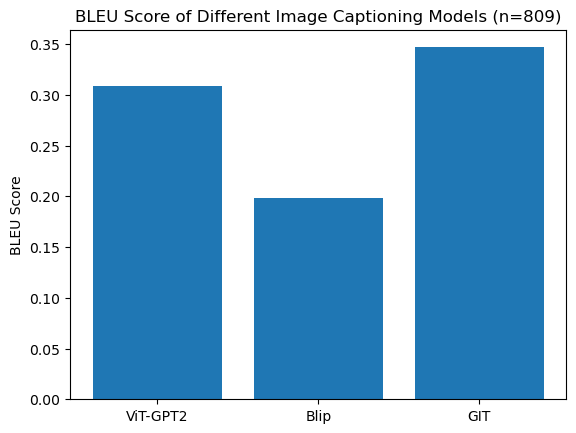

In [34]:
vit_gpt2_score = model_bleu_scores["ViT-GPT2"][0]
blip_score = model_bleu_scores["Blip"][0]
git_score = model_bleu_scores["GIT"][0]

# plot these 
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.bar(np.arange(3), [vit_gpt2_score, blip_score, git_score])
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["ViT-GPT2", "Blip", "GIT"])
ax.set_ylabel("BLEU Score")
ax.set_title("BLEU Score of Different Image Captioning Models (n=809)")
plt.show()


## Demo

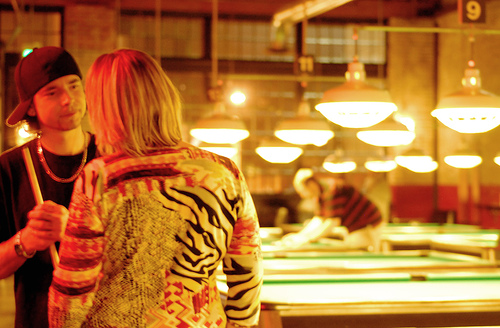

In [38]:
image = random.choice(image_names)
image_to_be_captioned = Image.open(f"../data/flickr8k/images/{image}")
image_to_be_captioned

In [39]:
print("generating ViT-GPT2 caption...")
print(vip_gpt2_pipeline(image_to_be_captioned)[0]["generated_text"])
print()
print("generating Blip caption...")
print(blip_pipeline(image_to_be_captioned)[0]["generated_text"])
print()
print("generating GIT caption...")
print(git_pipe(image))
print()
print("actual caption...")
print(index_to_caption[image_name_to_index[image]])

generating ViT-GPT2 caption...
a woman standing next to a man in a restaurant 

generating Blip caption...
a man and woman standing in a restaurant

generating GIT caption...
a woman in a jacket standing in front of a table with a table and lights.

actual caption...
A girl in a petterned shirt is talking to a guy with a hat in a billiards room .
